# 数据增强可视化脚本

GridMask 和 HidePatch 在 torchvision 中没有实现无法直接导入，因此此代码首先给出算法实现。

使用方法：见最后一个 cell main

In [16]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import pdb
import math

class Grid(object):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        self.d1 = d1
        self.d2 = d2
        self.rotate = rotate
        self.ratio = ratio
        self.mode=mode
        self.st_prob = self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * min(1, epoch / max_epoch)

    def __call__(self, img):
        if np.random.rand() > self.prob:
            return img
        h = img.size(1)
        w = img.size(2)
        
        # 1.5 * h, 1.5 * w works fine with the squared images
        # But with rectangular input, the mask might not be able to recover back to the input image shape
        # A square mask with edge length equal to the diagnoal of the input image 
        # will be able to cover all the image spot after the rotation. This is also the minimum square.
        hh = math.ceil((math.sqrt(h*h + w*w)))
        
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
        
        # maybe use ceil? but i guess no big difference
        self.l = math.ceil(d*self.ratio)
        
        mask = np.ones((hh, hh), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        for i in range(-1, hh//d+1):
                s = d*i + st_h
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[s:t,:] *= 0
        for i in range(-1, hh//d+1):
                s = d*i + st_w
                t = s+self.l
                s = max(min(s, hh), 0)
                t = max(min(t, hh), 0)
                mask[:,s:t] *= 0
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (hh-w)//2:(hh-w)//2+w]

        mask = torch.from_numpy(mask).float()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        img = img * mask 

        return img

class GridMask(nn.Module):
    def __init__(self, d1, d2, rotate = 1, ratio = 0.5, mode=0, prob=1.):
        super(GridMask, self).__init__()
        self.rotate = rotate
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.grid = Grid(d1, d2, rotate, ratio, mode, prob)

    def set_prob(self, epoch, max_epoch):
        self.grid.set_prob(epoch, max_epoch)

    def forward(self, x):
        if not self.training:
            return x
        c,h,w = x.size()
        y = []
        # for i in range(n):
        y.append(self.grid(x))
        y = torch.cat(y).view(c,h,w)
        return y


(830, 761)


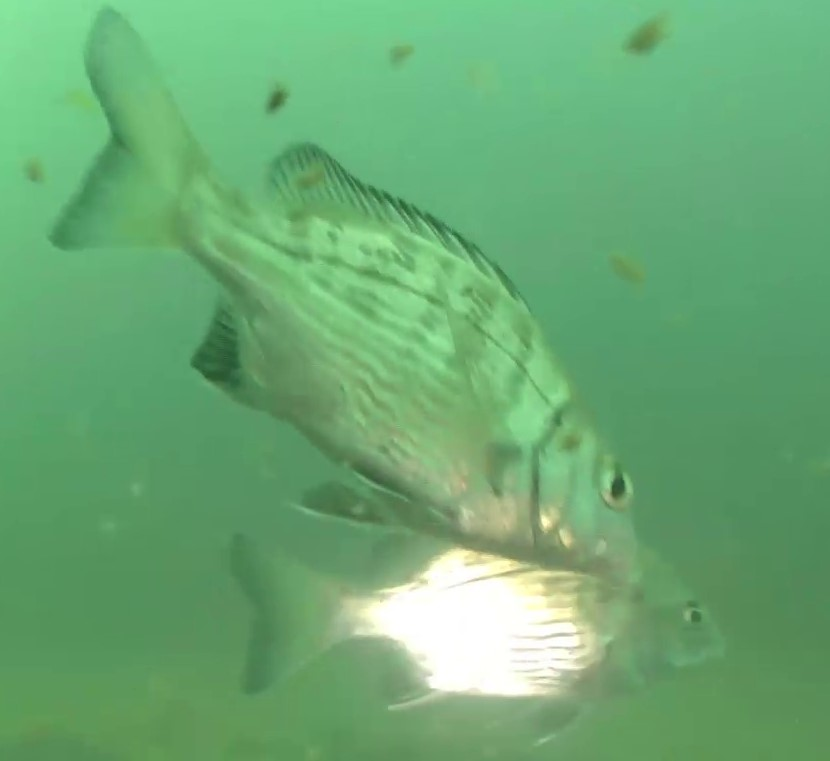

img.size()[2]: 128
cost time: 0.0009505748748779297


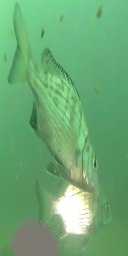

(128, 256)
img.size()[2]: 128
cost time: 0.0009162425994873047


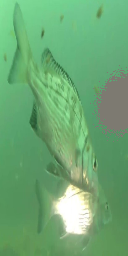

(128, 256)


In [18]:
from typing import Any
from torchvision.transforms import *

from PIL import Image
import random
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import torchvision.transforms as T

class GaussianErasing(object):
    """
    利用二维各向异性高斯核对 RandomErasing 遮挡区域进行拉伸变换
    
    
    """
    
    def __init__(self,probability=0.5,sl=0.09,sh=0.7,ratiol=1,ratioh=5,thetal=-89,thetah=89,mean=[0.4914, 0.4822, 0.4465],density=0.5,scalar=10) -> None:
        '''
        init 给出的是参数的变化范围
        
        probability: 进行 GaussianErasing 的概率
        sl: 覆盖面积的下限
        sh: 覆盖面积的上限
        ratiol: sigma2/sigma1 的下限
        ratioh: sigma2/sigma1 的上限
        thetal: 旋转角度下限
        thetah: 旋转角度上限
        mean: [] 替换的像素值,默认为 ImageNet 数据集均值(ReID 数据集没算)
        
        '''
        self.probability = probability
        self.sl = sl
        self.sh = sh
        
        self.ratiol = ratiol
        self.ratioh = ratioh
        self.thetal = thetal
        self.thetah = thetah
        self.mean = mean
        self.density = density
        self.scalar = scalar
    
    def __call__(self, img) -> Any:
        if random.uniform(0,1) > self.probability:
            return img

        # 进行多次随机数生成保证出现合法值
        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
            
            # 随机生成参数
            target_area = random.uniform(self.sl,self.sh) * area
            aspect_ratio = random.uniform(self.ratiol,self.ratioh)
            theta = random.uniform(self.thetal,self.thetah) * np.pi / 180   # 转化成弧度制
            
            w = np.sqrt(target_area / aspect_ratio) / 5         # 高斯分布短轴
            h = np.sqrt(target_area * aspect_ratio) / 5         # 高斯分布长轴
            
            # 其中 sigma1 固定为 1.0，与分布的关系为 w = 5 x sigma1
            sigma1 = 1
            sigma2 = aspect_ratio * sigma1
            
            
            # phi = arctan(sigma1 / sigma2) = arctan(1/r)
            phi = np.arctan(1 / aspect_ratio)
            
            # 计算限制区域 W 和 H
            hypotenuse = np.sqrt((5*w)**2+(5*h)**2)   # 斜边
            
            if theta >= 0:
                W = hypotenuse * np.sin(theta+phi)
                H = hypotenuse * np.cos(theta-phi)
            else :
                _theta = -1 * theta
                W = hypotenuse * np.sin(_theta+phi)
                H = hypotenuse * np.cos(_theta-phi)

            W = int(W)
            H = int(H)
            
            print("img.size()[2]:" ,img.size()[2])
            
            mask = generate_gaussian_mask(sigma1=sigma1,sigma2=sigma2,theta=theta,w=W,h=H,density=self.density,scalar=self.scalar)
                                   
            if W // 2 < img.size()[2] and H // 2 < img.size()[1]:
                # 创建扩展的 img
                expand_img = torch.zeros(img.size()[0],img.size()[1]+H,img.size()[2]+W)
                expand_img[:,H//2:H//2+img.size()[1],W//2:W//2+img.size()[2]] = img[:,:,:]
                
                x1 = random.randint(0, expand_img.size()[1] - H)
                y1 = random.randint(0, expand_img.size()[2] - W)
                if expand_img.size()[0] == 3:
                    # 使用 Mask 赋值，在数据增强中只使用一个 Mask
                    expand_img[:, x1:x1+H, y1:y1+W] = expand_img[:, x1:x1+H, y1:y1+W] * (1-mask)
                    
                    # 创造替换值掩膜
                    add_mask = (torch.ones(mask.size())).repeat(3,1,1)
                    add_mask = add_mask * mask
                    add_mask[0,:,:] = add_mask[0,:,:] * self.mean[0]
                    add_mask[1,:,:] = add_mask[1,:,:] * self.mean[1]
                    add_mask[2,:,:] = add_mask[2,:,:] * self.mean[2]
                    # 填补空洞
                    expand_img[:, x1:x1+H, y1:y1+W] = expand_img[:, x1:x1+H, y1:y1+W] + add_mask
                else:
                    expand_img[0, x1:x1+H, y1:y1+W] = expand_img[0, x1:x1+H, y1:y1+W] * (1-mask)
                    add_mask = (torch.ones(mask.size())).repeat(1,1,1)
                    add_mask = add_mask * mask
                    add_mask[0,:,:] = add_mask[0,:,:] * self.mean[0]
                    expand_img[:, x1:x1+H, y1:y1+W] = expand_img[:, x1:x1+H, y1:y1+W] + add_mask
                
                
                # expand_img1 = transforms.ToPILImage()(expand_img)
                # expand_img1.show()
                
                # 再截取出 img
                img[:,:,:] = expand_img[:,H//2:H//2+img.size()[1],W//2:W//2+img.size()[2]]
                
                return img
        
        return img

def generate_gaussian_mask(sigma1,sigma2,theta,w,h,density=0.5,scalar=10):
    """
    生成指定尺度的高斯掩膜
    
    sigma1:
    sigma2:
    theta: 弧度制
    
    return: mask(Tensor)[h,w]
    
    """
    
    w = int(w)
    h = int(h)
    
    if np.abs(theta) > 3.14:
        theta = theta * np.pi / 180
    
    # 尺度矩阵
    thetaMatrix=np.dot(np.matrix([[sigma1**2,0],[0,sigma2**2]]),np.identity(2))

    # 旋转矩阵
    rotationMatrix=np.matrix([[np.cos(theta),-1*np.sin(theta)],
                            [np.sin(theta),np.cos(theta)]])
    
    # 协方差矩阵
    covMatrix=np.dot(np.dot(rotationMatrix,thetaMatrix),rotationMatrix.transpose()) 
    
    # 产生随机数
    pts = np.random.multivariate_normal([0, 0], covMatrix, size=int(w*h*density))
    # 产生坐标 
    X = torch.Tensor(pts[:,0])      # 横坐标，w
    Y = torch.Tensor(pts[:,1])      # 纵坐标，h
    # 向量拼接
    locs = torch.stack((Y,X),dim=1)
    
    # 尺度缩放与平移
    pts = (locs* scalar).int()           # locs x 尺度缩放倍数
    pts[:,0] = pts[:,0] + h //2     # h
    pts[:,1] = pts[:,1] + w //2     # w
        
    # plt.plot(pts[:, 1], pts[:, 0], '.', alpha=0.5)
    # plt.axis('equal')
    # plt.grid()
    # plt.show()
    
    #限定到 Kernel 范围内
    select_mask = (pts[:,0]>=0)&(pts[:,0]<h)&(pts[:,1]>=0)&(pts[:,1]<w)
    pts = pts[select_mask]              # 选择
    pts = torch.unique(pts,dim=0)       # 去重
    
    # 创建kernel
    mask = torch.zeros(h,w) 
        
    # 为 kernel 赋值
    # pts = 
    # for _loc in pts:
    #     mask[tuple(_loc)] = 1
    lx = torch.LongTensor(pts[:,0].numpy()) 
    ly = torch.LongTensor(pts[:,1].numpy()) 
    replace_value = torch.ones_like(pts[:,0],dtype=mask.dtype)
    mask = mask.index_put((lx,ly),replace_value)
    
    
    return mask
    

        
# if __name__ == '__main__':
#     # generate_gaussian_mask(1,1,45,20,50)
#     img = Image.open('/home/kzy/project/Remote-BoT-SORT/mytools/Erasing/img/225-1.jpg')
#     print(img.size)
#     img.show()
#     trans = T.Compose([
#                 # transforms.Resize(256),
#                 # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
#                 # transforms.RandomErasing(p=1,value=[0.4914, 0.4822, 0.4465])
#                 T.ToTensor(),
#                 T.Resize([256, 128]) ,
#                 GaussianErasing(probability=1.0,thetal=-30,thetah=30,sl=0.2,sh=0.8,ratioh=3,density=2.5,scalar=7.5),
#                 # HidePatch()
               
#                 ]) 

    
#     for _ in range(2):
#         img1 = trans(img)
#         time1 = time.time()
        
#         img1 = T.ToPILImage()(img1)
#         time2 = time.time()
        
#         print('cost time:',time2-time1)
#         img1.show()
#         print(img1.size)
#         # img1.save('./'+str(_)+'.jpg')
        

(830, 761)


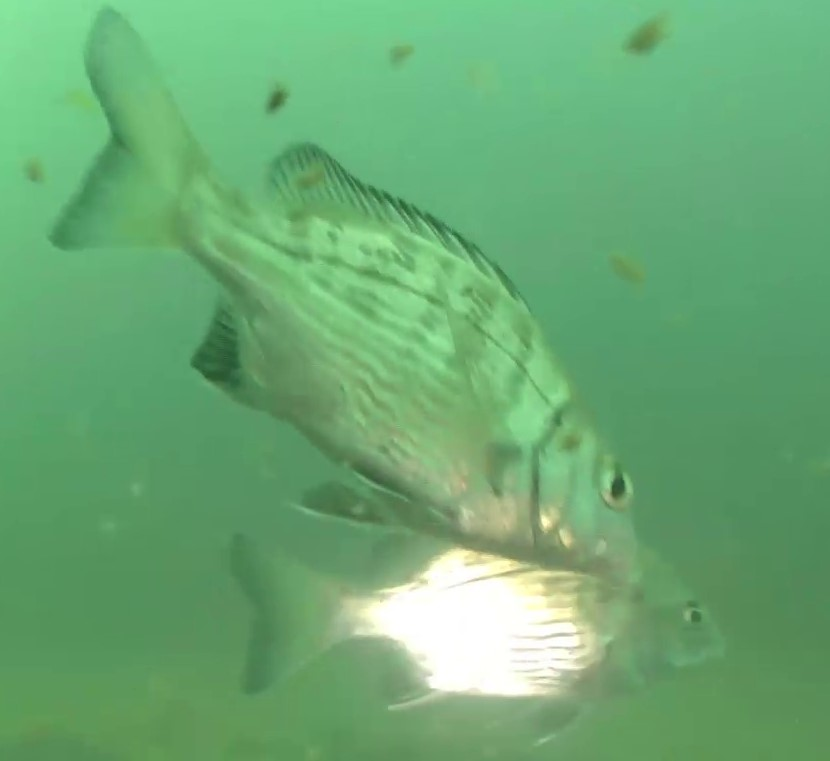

img.size()[2]: 220
cost time: 0.0007648468017578125


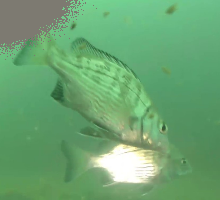

(220, 200)
img.size()[2]: 220
cost time: 0.0011186599731445312


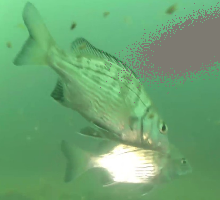

(220, 200)
img.size()[2]: 220
cost time: 0.0007998943328857422


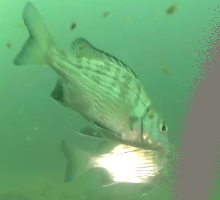

(220, 200)
img.size()[2]: 220
cost time: 0.0008122920989990234


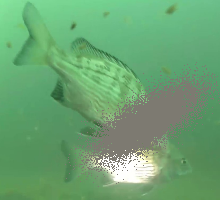

(220, 200)
img.size()[2]: 220
cost time: 0.0007672309875488281


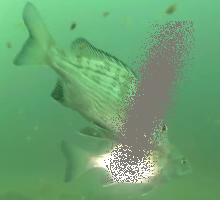

(220, 200)
img.size()[2]: 220
cost time: 0.0007696151733398438


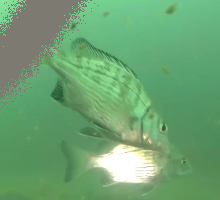

(220, 200)
img.size()[2]: 220
cost time: 0.0007977485656738281


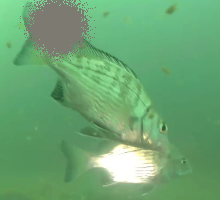

(220, 200)
img.size()[2]: 220
cost time: 0.0008831024169921875


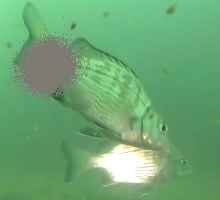

(220, 200)
img.size()[2]: 220
cost time: 0.0008609294891357422


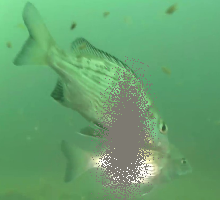

(220, 200)
img.size()[2]: 220
cost time: 0.0008130073547363281


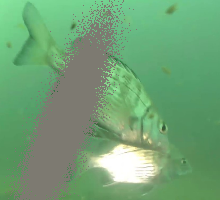

(220, 200)
img.size()[2]: 220
cost time: 0.0008080005645751953


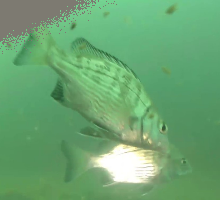

(220, 200)
img.size()[2]: 220
cost time: 0.0007386207580566406


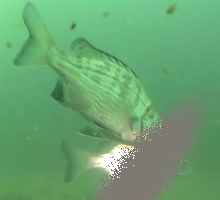

(220, 200)
img.size()[2]: 220
cost time: 0.00109100341796875


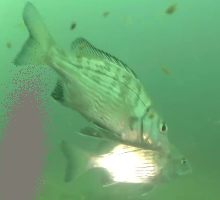

(220, 200)
img.size()[2]: 220
cost time: 0.0011310577392578125


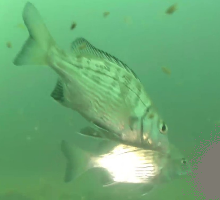

(220, 200)
img.size()[2]: 220
cost time: 0.0010981559753417969


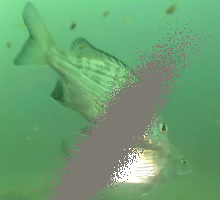

(220, 200)
img.size()[2]: 220
cost time: 0.0011103153228759766


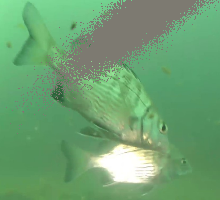

(220, 200)
img.size()[2]: 220
cost time: 0.0011742115020751953


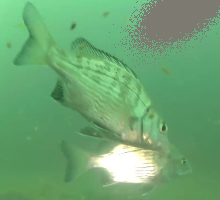

(220, 200)
img.size()[2]: 220
cost time: 0.0011241436004638672


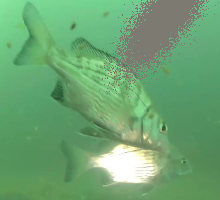

(220, 200)
img.size()[2]: 220
cost time: 0.0011196136474609375


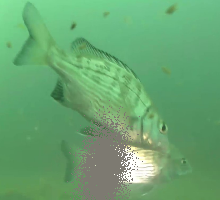

(220, 200)
img.size()[2]: 220
cost time: 0.0011396408081054688


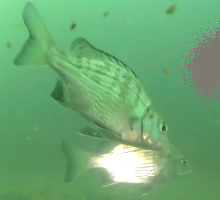

(220, 200)


In [23]:
from typing import Any
from torchvision.transforms import *
from torchvision.transforms import functional as F

from PIL import Image
import random
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import torchvision.transforms as T

class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
 
 
class HidePatch(object):
    def __init__(self, hide_prob=0.5):
        self.hide_prob = hide_prob
 
    def __call__(self, img):
        # get width and height of the image
        # wd, ht = F.get_image_size(img)
        c,wd, ht = img.shape
 
        grid_size = 20   # For cifar, the patch size is set to be 8.
 
        # hide the patches
        if grid_size > 0:
            # img = np.asarray(img)
            for x in range(0, wd, grid_size):
                for y in range(0, ht, grid_size):
                    x_end = min(wd, x + grid_size)
                    y_end = min(ht, y + grid_size)
                    if random.random() <= self.hide_prob:
                        img[:,x:x_end, y:y_end] = 0

        return img
        # return Image.fromarray(img)
    
        
if __name__ == '__main__':
    
    # STEP 1. 修改输入图像路径
    img = Image.open('/home/kzy/project/Remote-BoT-SORT/mytools/Erasing/img/225-1.jpg')
    print(img.size)
    img.show()
    
    # STEP 2. 修改注释，选择使用具体的数据增强方法
    trans = T.Compose([
                # transforms.Resize(256),
                # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                # transforms.RandomErasing(p=1,value=[0.4914, 0.4822, 0.4465])
                
                T.ToTensor(),
                T.Resize([200, 220]), 
                # p 固定为1，thetal ,density:生成密度; ratioh:长短轴的比例, [thetal,thetah]:[0,90], 
                GaussianErasing(probability=1.0,thetal=0,density=1,ratioh=2),   
                # T.RandomErasing(p=1.0,value=[0.4914, 0.4822, 0.4465])    # p 是擦除概率，此处设为 1.0 固定出发即可
                # Cutout(n_holes=1,length=100)                             # 
                # GridMask(50,70,mode=1)                                   # d1,d2 : Grid 的宽高
                # HidePatch(hide_prob=0.3)                                 # hide_prob: 最大面积
               
                ]) 

    # STEP 3. 修改循环次数，决定尝试次数
    for _ in range(20):
        
        img1 = trans(img)
        time1 = time.time()
        
        img1 = T.ToPILImage()(img1)
        time2 = time.time()
        
        print('cost time:',time2-time1)
        img1.show()
        print(img1.size)